# Esercizio 6 — Modelli Lineari: Logistic Regression e Linear Regression

---

## 🎯 Obiettivi del Notebook
1. **Comprendere la geometria dei modelli lineari** — iperpiano, decision boundary, combinazione lineare
2. **Padroneggiare Logistic Regression** — log-odds, sigmoide, probabilità, metriche di classificazione
3. **Padroneggiare Linear Regression** — MSE, RMSE, R², interpretazione coefficienti
4. **Standardizzazione e preprocessing** — perché e come normalizzare le feature
5. **Interpretare i coefficienti** — odds ratio, effetto marginale, confronto magnitudini

---

## ✅ Prerequisiti
- Esercizio 5: Introduzione a Scikit-Learn (pipeline base, train_test_split, StandardScaler)
- Python base, NumPy, Pandas
- Concetti: feature, target, training set, test set

---

## 📚 Indice
1. [SEZIONE 1 — Teoria](#sezione-1)
2. [SEZIONE 2 — Mappa Mentale](#sezione-2)
3. [SEZIONE 3 — Notebook Dimostrativo](#sezione-3)
4. [SEZIONE 4 — Metodi Spiegati](#sezione-4)
5. [SEZIONE 5 — Glossario](#sezione-5)
6. [SEZIONE 6 — Errori Comuni](#sezione-6)
7. [SEZIONE 7 — Conclusione](#sezione-7)
8. [SEZIONE 8 — Checklist](#sezione-8)
9. [SEZIONE 9 — Changelog](#sezione-9)

<a id="sezione-1"></a>
# SEZIONE 1 — Teoria

---

## 1.1 Il Modello Lineare: Geometria Fondamentale

Un modello lineare approssima la relazione tra feature $\mathbf{x}$ e target $y$ come **combinazione lineare**:

$$\hat{y} = w_1 x_1 + w_2 x_2 + \dots + w_n x_n + b = \mathbf{w}^T \mathbf{x} + b$$

| Componente | Significato | Geometria |
|------------|-------------|-----------|
| $w_i$ (peso) | Quanto cambia $\hat{y}$ quando $x_i$ aumenta di 1 | Pendenza nella direzione $i$ |
| $b$ (bias) | Valore base quando tutte le $x_i = 0$ | Traslazione dell'iperpiano |
| **Iperpiano** | $\mathbf{w}^T \mathbf{x} + b = 0$ | Superficie decisionale in dim. $n$ |

---

## 1.2 Logistic Regression (Classificazione)

Per classificazione binaria, trasformiamo l'output lineare in **probabilità**:

### Step 1: Calcolo del logit
$$z = \mathbf{w}^T \mathbf{x} + b$$

### Step 2: Funzione sigmoide
$$\sigma(z) = \frac{1}{1 + e^{-z}} \in (0, 1)$$

### Step 3: Previsione di probabilità
$$\hat{p} = P(y=1 \mid \mathbf{x}) = \sigma(\mathbf{w}^T \mathbf{x} + b)$$

### Interpretazione coefficienti (Odds Ratio)
$$\text{Odds} = \frac{p}{1-p} \quad \Rightarrow \quad \log(\text{Odds}) = \mathbf{w}^T \mathbf{x} + b$$

Se $w_i = 0.5$, allora $e^{0.5} \approx 1.65$ → gli odds **aumentano del 65%** quando $x_i$ cresce di 1.

---

## 1.3 Linear Regression (Regressione)

Per target continui, minimizziamo l'**errore quadratico medio**:

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$$

### Metriche di valutazione

| Metrica | Formula | Interpretazione |
|---------|---------|-----------------|
| **RMSE** | $\sqrt{\frac{1}{n}\sum (y_i - \hat{y}_i)^2}$ | Errore medio nella scala del target |
| **R²** | $1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}$ | % di varianza spiegata (0=nullo, 1=perfetto) |

---

## 1.4 Perché Standardizzare?

| Problema senza standardizzazione | Soluzione |
|----------------------------------|-----------|
| Feature con scale diverse dominano il gradiente | Normalizzare: $x' = \frac{x - \mu}{\sigma}$ |
| Coefficienti non comparabili | Dopo std, 1 unità = 1 deviazione standard |
| Convergenza lenta del solver | Media 0, varianza 1 → gradiente bilanciato |

---

## 1.5 Confronto Logistic vs Linear

| Aspetto | Logistic Regression | Linear Regression |
|---------|---------------------|-------------------|
| **Target** | Binario (0/1) | Continuo |
| **Output** | Probabilità (0-1) | Valore numerico |
| **Loss** | Cross-entropy (log loss) | MSE |
| **Interpretazione** | Log-odds, odds ratio | Effetto marginale diretto |
| **Decision** | Soglia (default 0.5) | N/A |

---

## 1.6 Forze e Limiti

**✅ Punti di forza:**
- Interpretabilità estrema
- Addestramento rapido
- Baseline robusta
- Funziona bene con poche feature

**⚠️ Limiti:**
- Assume relazioni lineari
- Sensibile a outlier
- Non cattura interazioni senza feature engineering

<a id="sezione-2"></a>
# SEZIONE 2 — Mappa Mentale

---

```
                    ┌─────────────────────────────────────────┐
                    │         MODELLI LINEARI                 │
                    │   ŷ = w₁x₁ + w₂x₂ + ... + wₙxₙ + b      │
                    └───────────────────┬─────────────────────┘
                                        │
            ┌───────────────────────────┼───────────────────────────┐
            ▼                           ▼                           ▼
   ┌────────────────┐         ┌────────────────┐         ┌────────────────┐
   │  PREPROCESSING │         │ CLASSIFICAZIONE│         │  REGRESSIONE   │
   │                │         │                │         │                │
   │ StandardScaler │         │   Logistic     │         │    Linear      │
   │ x'=(x-μ)/σ     │         │   Regression   │         │   Regression   │
   └────────┬───────┘         └───────┬────────┘         └───────┬────────┘
            │                         │                          │
            ▼                         ▼                          ▼
   ┌────────────────┐         ┌────────────────┐         ┌────────────────┐
   │ • Comparabilità│         │ z = wᵀx + b   │         │ ŷ = wᵀx + b   │
   │   coefficienti │         │ σ(z) = 1/(1+e⁻ᶻ)       │ min MSE        │
   │ • Convergenza  │         │ P(y=1) = σ(z) │         │                │
   │   veloce       │         │                │         │                │
   └────────────────┘         └───────┬────────┘         └───────┬────────┘
                                      │                          │
                    ┌─────────────────┴─────────┐    ┌───────────┴───────────┐
                    ▼                           ▼    ▼                       ▼
           ┌──────────────┐            ┌──────────────┐            ┌──────────────┐
           │   METRICHE   │            │ COEFFICIENTI │            │   METRICHE   │
           │              │            │              │            │              │
           │ • Accuracy   │            │ • Segno →    │            │ • RMSE       │
           │ • Precision  │            │   direzione  │            │ • R²         │
           │ • Recall     │            │ • |w| →      │            │              │
           └──────────────┘            │   importanza │            └──────────────┘
                                       │ • exp(w) →   │
                                       │   odds ratio │
                                       └──────────────┘
```

---

## Flusso Operativo

```
[Dati Grezzi] → [EDA: balance, missing, duplicati]
                            │
                            ▼
              [train_test_split(stratify=y)]
                            │
                            ▼
              [StandardScaler: fit su train, transform su test]
                            │
                ┌───────────┴───────────┐
                ▼                       ▼
        [LogisticRegression]    [LinearRegression]
                │                       │
                ▼                       ▼
        [accuracy, precision,   [RMSE, R²]
         recall, predict_proba]
                │                       │
                └───────────┬───────────┘
                            ▼
              [Interpretazione Coefficienti]
              [Validazione Business Sense]
```

<a id="sezione-3"></a>
# SEZIONE 3 — Notebook Dimostrativo

---

## Esercizio 1: Pipeline Completa di Logistic Regression

Costruiamo una pipeline completa: dati sintetici → EDA → split → scaling → modello → metriche.

### Perché questo passaggio?
Importiamo le librerie necessarie: NumPy per calcoli, Pandas per dati tabulari, Matplotlib per grafici, Scikit-Learn per ML.

In [39]:
# === IMPORT LIBRERIE ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    mean_squared_error,
    r2_score,
)
from sklearn.datasets import make_classification, make_regression

# --- MICRO-CHECKPOINT ---
assert 'LogisticRegression' in dir(), "LogisticRegression non importato"
assert 'LinearRegression' in dir(), "LinearRegression non importato"
print("✓ Micro-checkpoint: tutte le librerie importate correttamente")

✓ Micro-checkpoint: tutte le librerie importate correttamente


### Perché questo passaggio?
Generiamo un dataset sintetico di classificazione binaria con `make_classification`. Controlliamo il bilanciamento delle classi (60%-40%).

In [40]:
# === STEP 1: GENERAZIONE DATASET BINARIO ===
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=6,
    n_redundant=2,
    n_classes=2,
    weights=[0.6, 0.4],  # 60% classe 0, 40% classe 1
    class_sep=1.0,
    random_state=42,
)

# Creiamo DataFrame per ispezione
df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
df["target"] = y

# --- MICRO-CHECKPOINT ---
pos_ratio = y.mean()
assert X.shape == (1000, 10), f"Shape atteso (1000, 10), ottenuto {X.shape}"
assert 0.35 < pos_ratio < 0.45, f"Positive ratio fuori range: {pos_ratio:.2f}"
print(f"✓ Micro-checkpoint: Shape={X.shape}, Positive ratio={pos_ratio:.2f}")
df.head()

✓ Micro-checkpoint: Shape=(1000, 10), Positive ratio=0.40


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target
0,-1.030931,1.391626,0.547274,0.928932,-1.738880,1.250002,1.332551,1.578256,2.124722,-0.318434,0
1,-2.766254,1.247870,-0.303691,1.083145,0.710836,1.968202,-1.794192,2.346422,1.700778,-0.001190,1
2,-0.558987,0.299849,1.527071,0.360442,-1.360209,1.100793,-0.755951,1.331933,2.041105,-0.824404,0
3,-1.350289,-2.046078,-0.614264,0.126459,-0.783923,5.895026,-0.915477,-3.184768,-0.399260,-3.920960,0
4,-0.275754,-0.728495,0.027727,-0.660834,-1.928161,3.544945,1.446944,-1.111662,0.313766,-2.376528,0


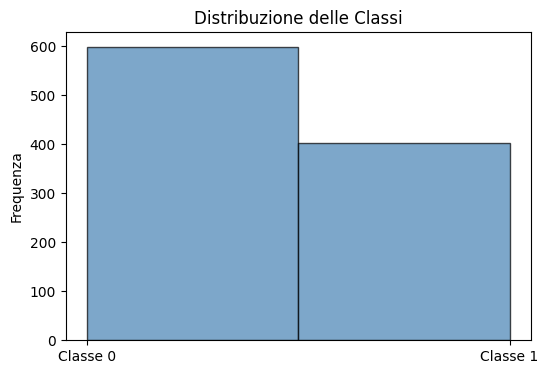

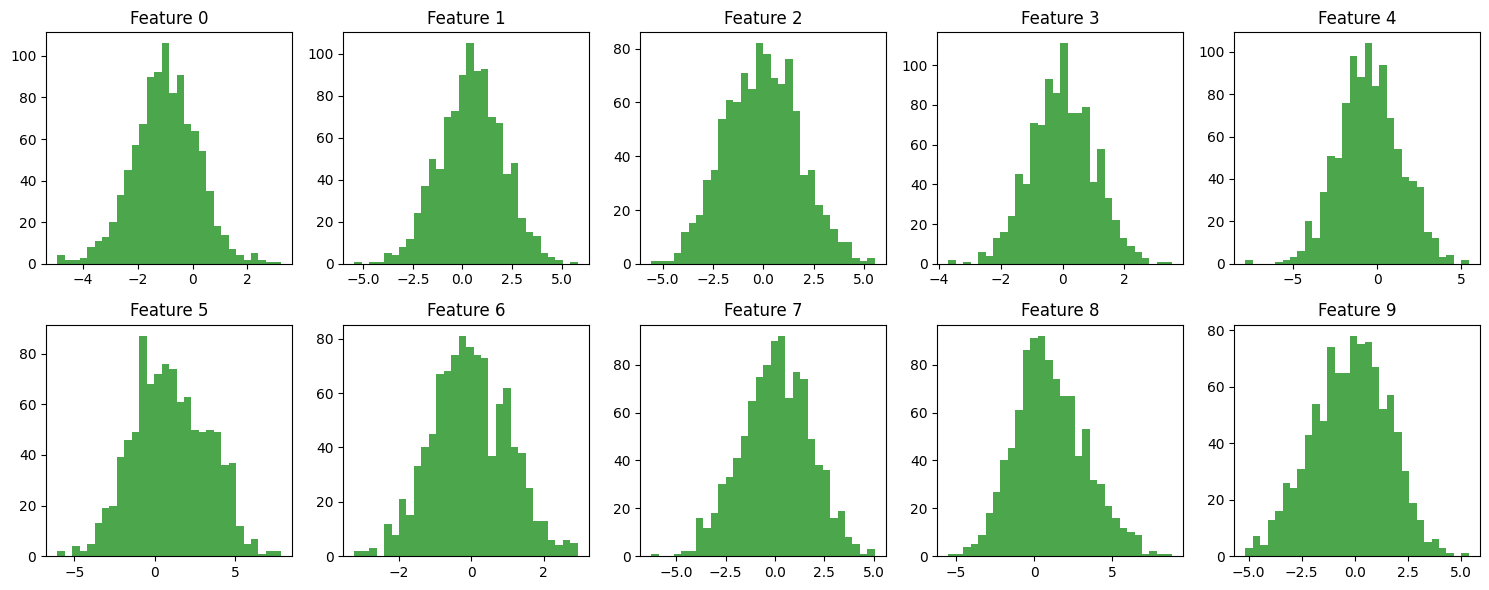

✓ Micro-checkpoint: 0 duplicati, 0 missing values
  Dataset shape: (1000, 11)


In [41]:
# === STEP 2: EDA - ESPLORAZIONE DATI ===

# Distribuzione delle classi
plt.figure(figsize=(6, 4))
plt.hist(df["target"], bins=2, alpha=0.7, color="steelblue", edgecolor="black")
plt.xticks([0, 1], ["Classe 0", "Classe 1"])
plt.title("Distribuzione delle Classi")
plt.ylabel("Frequenza")
plt.show()

# Distribuzione delle feature
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.hist(df[f"feature_{i}"], bins=30, alpha=0.7, color="green")
    ax.set_title(f"Feature {i}")
plt.tight_layout()
plt.show()

# Controlli qualità
duplicates = df.duplicated().sum()
missing = df.isnull().sum().sum()

# --- MICRO-CHECKPOINT ---
assert duplicates == 0, f"Trovati {duplicates} duplicati!"
assert missing == 0, f"Trovati {missing} valori mancanti!"
print(f"✓ Micro-checkpoint: 0 duplicati, 0 missing values")
print(f"  Dataset shape: {df.shape}")

### Perché questo passaggio?
Dividiamo in train (80%) e test (20%). Il parametro `stratify=y` mantiene le proporzioni delle classi in entrambi i set.

In [42]:
# === STEP 3: TRAIN/TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Verifica proporzioni
train_ratio = y_train.mean()
test_ratio = y_test.mean()

# --- MICRO-CHECKPOINT ---
assert X_train.shape[0] == 800, f"Train size atteso 800, ottenuto {X_train.shape[0]}"
assert X_test.shape[0] == 200, f"Test size atteso 200, ottenuto {X_test.shape[0]}"
assert abs(train_ratio - test_ratio) < 0.05, "Stratificazione fallita!"
print(f"✓ Micro-checkpoint: Train={X_train.shape}, Test={X_test.shape}")
print(f"  Train positive ratio: {train_ratio:.2f}, Test positive ratio: {test_ratio:.2f}")

✓ Micro-checkpoint: Train=(800, 10), Test=(200, 10)
  Train positive ratio: 0.40, Test positive ratio: 0.40


### Perché questo passaggio?
Standardizziamo le feature: `fit_transform` sul train (calcola μ e σ), `transform` sul test (usa μ e σ del train). Così evitiamo data leakage.

In [ ]:
# === STEP 4: STANDARDIZZAZIONE ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Calcola μ, σ su train
X_test_scaled = scaler.transform(X_test)        # Usa μ, σ del train

# Verifica: dopo standardizzazione, media ≈ 0 e std ≈ 1 sul train
train_means = X_train_scaled.mean(axis=0)
train_stds = X_train_scaled.std(axis=0)

# --- MICRO-CHECKPOINT ---
assert np.allclose(train_means, 0, atol=1e-10), "Medie non nulle dopo standardizzazione!"
assert np.allclose(train_stds, 1, atol=1e-10), "Std non unitarie dopo standardizzazione!"
print(f"✓ Micro-checkpoint: Media train ≈ {train_means.mean():.6f}, Std train ≈ {train_stds.mean():.4f}")

### Perché questo passaggio?
Addestriamo il modello di Logistic Regression. Il parametro `max_iter=1000` evita warning di convergenza.

In [ ]:
# === STEP 5: ADDESTRAMENTO LOGISTIC REGRESSION ===
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# --- MICRO-CHECKPOINT ---
assert hasattr(log_reg, 'coef_'), "Modello non addestrato!"
assert log_reg.coef_.shape == (1, 10), f"Shape coefficienti errata: {log_reg.coef_.shape}"
print(f"✓ Micro-checkpoint: Modello addestrato con {log_reg.coef_.shape[1]} coefficienti")
print(f"  Intercept (bias): {log_reg.intercept_[0]:.4f}")

### Perché questo passaggio?
Valutiamo il modello con 3 metriche complementari: **Accuracy** (correttezza globale), **Precision** (quanti positivi predetti sono veri), **Recall** (quanti positivi veri abbiamo trovato).

In [ ]:
# === STEP 6: VALUTAZIONE METRICHE ===
y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]  # Probabilità classe 1

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# --- MICRO-CHECKPOINT ---
assert 0 <= accuracy <= 1, "Accuracy fuori range!"
assert 0 <= precision <= 1, "Precision fuori range!"
assert 0 <= recall <= 1, "Recall fuori range!"
print(f"✓ Micro-checkpoint: Metriche calcolate correttamente")
print(f"  Accuracy:  {accuracy:.3f}")
print(f"  Precision: {precision:.3f}")
print(f"  Recall:    {recall:.3f}")
print(f"  Probabilità medie: classe 0 = {y_proba[y_test==0].mean():.3f}, classe 1 = {y_proba[y_test==1].mean():.3f}")

---

## Esercizio 2: Interpretazione dei Coefficienti

I coefficienti della Logistic Regression indicano come varia il **log-odds**. L'**odds ratio** $e^{w_i}$ ci dice quanto cambiano gli odds quando la feature aumenta di 1 unità.

### Perché questo passaggio?
Estraiamo i coefficienti, li ordiniamo per magnitudine e calcoliamo gli odds ratio per interpretare l'effetto di ogni feature.

In [43]:
# === INTERPRETAZIONE COEFFICIENTI ===
coefficients = log_reg.coef_[0]
feature_names = [f"feature_{i}" for i in range(X.shape[1])]

# DataFrame con coefficienti e odds ratio
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients,
    "odds_ratio": np.exp(coefficients),
    "abs_coef": np.abs(coefficients)
}).sort_values("abs_coef", ascending=False)

# --- MICRO-CHECKPOINT ---
assert len(coef_df) == 10, "Numero coefficienti errato"
assert all(coef_df["odds_ratio"] > 0), "Odds ratio devono essere positivi!"
print("✓ Micro-checkpoint: Coefficienti estratti e ordinati")
print("\nInterpretazione:")
print("  - Coefficiente > 0 → aumenta P(y=1)")
print("  - Coefficiente < 0 → diminuisce P(y=1)")
print("  - Odds ratio > 1 → odds crescono, < 1 → odds calano")
coef_df

✓ Micro-checkpoint: Coefficienti estratti e ordinati

Interpretazione:
  - Coefficiente > 0 → aumenta P(y=1)
  - Coefficiente < 0 → diminuisce P(y=1)
  - Odds ratio > 1 → odds crescono, < 1 → odds calano


,feature,coefficient,odds_ratio,abs_coef
5,feature_5,-1.161549,0.313001,1.161549
9,feature_9,1.053712,2.868277,1.053712
4,feature_4,0.459241,1.582872,0.459241
1,feature_1,0.434214,1.543749,0.434214
8,feature_8,0.139125,1.149267,0.139125
6,feature_6,0.128376,1.136981,0.128376
0,feature_0,0.078696,1.081876,0.078696
2,feature_2,-0.050386,0.950863,0.050386
7,feature_7,0.014746,1.014855,0.014746
3,feature_3,-0.009750,0.990297,0.009750


---

## Esercizio 3: Linear Regression per Target Continui

Passiamo alla regressione: stimiamo un valore continuo minimizzando MSE.

### Perché questo passaggio?
Generiamo dati di regressione con `make_regression`. Il parametro `noise=10` aggiunge rumore realistico.

In [44]:
# === GENERAZIONE DATASET DI REGRESSIONE ===
X_reg, y_reg = make_regression(
    n_samples=800,
    n_features=8,
    n_informative=6,
    noise=10.0,
    bias=50.0,
    random_state=42
)

df_reg = pd.DataFrame(X_reg, columns=[f"feature_{i}" for i in range(8)])
df_reg["target"] = y_reg

# --- MICRO-CHECKPOINT ---
assert X_reg.shape == (800, 8), f"Shape atteso (800, 8), ottenuto {X_reg.shape}"
assert y_reg.mean() != 0, "Target con media nulla inattesa"
print(f"✓ Micro-checkpoint: Shape={X_reg.shape}")
print(f"  Target: media={y_reg.mean():.2f}, std={y_reg.std():.2f}")
df_reg.head()

✓ Micro-checkpoint: Shape=(800, 8)
  Target: media=45.97, std=115.89


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,target
0,-0.547996,-0.214150,-0.321159,-1.114081,-0.942060,0.837154,-1.585626,-0.630931,35.509587
1,0.340051,0.570613,-0.331308,-0.278963,0.790372,0.968185,-0.612237,-0.279760,128.787981
2,-1.382800,0.926178,-1.398568,-1.037246,-0.875618,1.909417,0.562969,-0.190339,178.406252
3,-1.962626,0.349650,0.095344,0.260442,-1.008555,-1.564803,-0.263448,-0.538842,-144.376047
4,-0.164242,0.697587,0.308010,0.205075,1.888437,-0.836092,-1.302845,-1.623383,-70.058566


In [45]:
# === SPLIT TRAIN/TEST PER REGRESSIONE ===
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# --- MICRO-CHECKPOINT ---
assert X_train_reg.shape[0] == 640, f"Train size atteso 640, ottenuto {X_train_reg.shape[0]}"
assert X_test_reg.shape[0] == 160, f"Test size atteso 160, ottenuto {X_test_reg.shape[0]}"
print(f"✓ Micro-checkpoint: Train={X_train_reg.shape}, Test={X_test_reg.shape}")

✓ Micro-checkpoint: Train=(640, 8), Test=(160, 8)


### Perché questo passaggio?
Addestriamo Linear Regression e verifichiamo che l'intercept (bias) sia vicino al valore impostato (50).

In [46]:
# === ADDESTRAMENTO LINEAR REGRESSION ===
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)

# --- MICRO-CHECKPOINT ---
assert hasattr(lin_reg, 'coef_'), "Modello non addestrato!"
assert len(lin_reg.coef_) == 8, f"Numero coefficienti errato: {len(lin_reg.coef_)}"
print(f"✓ Micro-checkpoint: Modello addestrato")
print(f"  Intercept (bias stimato): {lin_reg.intercept_:.2f} (vero: 50.0)")
print(f"  Numero coefficienti: {len(lin_reg.coef_)}")

✓ Micro-checkpoint: Modello addestrato
  Intercept (bias stimato): 49.30 (vero: 50.0)
  Numero coefficienti: 8


### Perché questo passaggio?
Valutiamo con RMSE (errore nella scala del target) e R² (varianza spiegata). R² vicino a 1 indica buon fit.

In [47]:
# === VALUTAZIONE METRICHE REGRESSIONE ===
y_pred_reg = lin_reg.predict(X_test_reg)

# Calcolo metriche
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

# Analisi residui
residuals = y_test_reg - y_pred_reg

# --- MICRO-CHECKPOINT ---
assert rmse > 0, "RMSE deve essere positivo"
assert 0 <= r2 <= 1, f"R² fuori range: {r2}"
print(f"✓ Micro-checkpoint: Metriche calcolate")
print(f"  RMSE: {rmse:.2f} (errore medio)")
print(f"  R²:   {r2:.3f} ({r2*100:.1f}% varianza spiegata)")
print(f"  Residui: media={residuals.mean():.4f}, std={residuals.std():.2f}")

✓ Micro-checkpoint: Metriche calcolate
  RMSE: 11.03 (errore medio)
  R²:   0.992 (99.2% varianza spiegata)
  Residui: media=1.3201, std=10.95


<a id="sezione-4"></a>
# SEZIONE 4 — Metodi Spiegati

---

## Scikit-Learn - Classificazione

| Metodo | Sintassi | Output | Quando usarlo |
|--------|----------|--------|---------------|
| `make_classification()` | `X, y = make_classification(n_samples, n_features, ...)` | `(ndarray, ndarray)` | Generare dati sintetici per test |
| `train_test_split()` | `X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y)` | 4 array | Dividere in train/test |
| `StandardScaler.fit_transform()` | `X_scaled = scaler.fit_transform(X_train)` | `ndarray` | Normalizzare (solo su train!) |
| `StandardScaler.transform()` | `X_test_scaled = scaler.transform(X_test)` | `ndarray` | Applicare stessa trasformazione a test |
| `LogisticRegression.fit()` | `model.fit(X_train, y_train)` | `self` | Addestrare il classificatore |
| `LogisticRegression.predict()` | `y_pred = model.predict(X_test)` | `ndarray` di 0/1 | Prevedere classi |
| `LogisticRegression.predict_proba()` | `proba = model.predict_proba(X_test)` | `ndarray (n, 2)` | Ottenere probabilità per classe |
| `accuracy_score()` | `accuracy_score(y_true, y_pred)` | `float` | Correttezza globale |
| `precision_score()` | `precision_score(y_true, y_pred)` | `float` | Quanti positivi predetti sono veri |
| `recall_score()` | `recall_score(y_true, y_pred)` | `float` | Quanti positivi veri sono stati trovati |

---

## Scikit-Learn - Regressione

| Metodo | Sintassi | Output | Quando usarlo |
|--------|----------|--------|---------------|
| `make_regression()` | `X, y = make_regression(n_samples, n_features, noise=10)` | `(ndarray, ndarray)` | Generare dati di regressione |
| `LinearRegression.fit()` | `model.fit(X_train, y_train)` | `self` | Addestrare il regressore |
| `LinearRegression.predict()` | `y_pred = model.predict(X_test)` | `ndarray` | Prevedere valori continui |
| `model.coef_` | `model.coef_` | `ndarray` | Accedere ai pesi del modello |
| `model.intercept_` | `model.intercept_` | `float` | Accedere al bias |
| `mean_squared_error()` | `mse = mean_squared_error(y_true, y_pred)` | `float` | Calcolare MSE |
| `r2_score()` | `r2 = r2_score(y_true, y_pred)` | `float` | Calcolare R² |

---

## Proprietà dei Modelli

| Attributo | Modello | Descrizione |
|-----------|---------|-------------|
| `.coef_` | Entrambi | Array dei pesi (1 per feature) |
| `.intercept_` | Entrambi | Bias (termine costante) |
| `.classes_` | LogisticRegression | Array delle classi (es. [0, 1]) |
| `.n_features_in_` | Entrambi | Numero di feature usate in training |

<a id="sezione-5"></a>
# SEZIONE 5 — Glossario

---

| Termine | Definizione |
|---------|-------------|
| **Feature** | Variabile di input che descrive l'osservazione (es. età, reddito, temperatura) |
| **Target** | Variabile da predire (classe per classificazione, valore per regressione) |
| **Iperpiano** | Superficie decisionale in spazio n-dimensionale: $\mathbf{w}^T\mathbf{x} + b = 0$ |
| **Decision Boundary** | Frontiera che separa le classi nel modello di classificazione |
| **Logit** | Trasformazione $\log\frac{p}{1-p}$ che mappa probabilità in $(-\infty, +\infty)$ |
| **Sigmoid/Sigmoide** | Funzione $\sigma(z) = \frac{1}{1+e^{-z}}$ che mappa $(-\infty, +\infty)$ in $(0, 1)$ |
| **Odds** | Rapporto $\frac{p}{1-p}$ tra probabilità di successo e insuccesso |
| **Odds Ratio** | $e^{w_i}$: quanto cambiano gli odds quando feature $i$ aumenta di 1 |
| **Coefficiente/Peso** | Valore $w_i$ che moltiplica la feature $i$ nella combinazione lineare |
| **Bias/Intercept** | Termine costante $b$ che trasla l'iperpiano |
| **MSE** | Mean Squared Error: $\frac{1}{n}\sum(y_i - \hat{y}_i)^2$ |
| **RMSE** | Root MSE: $\sqrt{MSE}$, errore nella scala del target |
| **R²** | Coefficiente di determinazione: $1 - \frac{SS_{res}}{SS_{tot}}$, varianza spiegata |
| **Standardizzazione** | Trasformazione $x' = \frac{x-\mu}{\sigma}$ per media 0 e varianza 1 |
| **Data Leakage** | Errore di usare informazioni del test set durante il training |
| **Stratify** | Parametro per mantenere proporzioni classi in train/test split |
| **Convergenza** | Quando l'algoritmo di ottimizzazione raggiunge una soluzione stabile |
| **Collinearità** | Quando due o più feature sono fortemente correlate (instabilità coefficienti) |
| **Residuo** | Differenza tra valore vero e predetto: $y_i - \hat{y}_i$ |
| **Cross-Entropy** | Loss function per classificazione: $-\sum y_i \log(\hat{p}_i)$ |

<a id="sezione-6"></a>
# SEZIONE 6 — Errori Comuni

---

| # | Errore | Perché è sbagliato | Correzione |
|---|--------|-------------------|------------|
| 1 | `scaler.fit_transform(X_test)` | Data leakage! Lo scaler impara statistiche del test | `scaler.transform(X_test)` (fit solo su train) |
| 2 | Usare `accuracy` su classi sbilanciate | Può essere alta anche predicendo sempre classe maggioritaria | Usare precision, recall, F1 o AUC |
| 3 | Confrontare coefficienti su feature non standardizzate | Scale diverse → magnitudini non comparabili | Standardizzare prima, poi interpretare |
| 4 | Dimenticare `stratify=y` in classificazione | Train e test possono avere distribuzioni diverse | `train_test_split(..., stratify=y)` |
| 5 | `model.predict_proba(X)[:, 0]` per P(y=1) | Colonna 0 è P(y=0)! | `model.predict_proba(X)[:, 1]` per P(y=1) |
| 6 | Non impostare `random_state` | Risultati non riproducibili | Sempre `random_state=42` (o altro valore fisso) |
| 7 | Usare Linear Regression per classificazione | Output non è probabilità, può essere < 0 o > 1 | Usare Logistic Regression per classificazione |
| 8 | Ignorare warning `ConvergenceWarning` | Il solver non ha convergito, risultati inaffidabili | Aumentare `max_iter` o normalizzare i dati |
| 9 | Interpretare R² negativo come errore | R² < 0 significa che il modello è peggio della media | Rivedere feature o tipo di modello |
| 10 | Confondere `coef_` shape in Logistic | Shape è `(1, n_features)` per binario, `(n_classes, n_features)` per multiclasse | Accedere con `coef_[0]` per binario |

<a id="sezione-7"></a>
# SEZIONE 7 — Conclusione

---

## Cosa abbiamo imparato

1. **Modelli lineari** esprimono la relazione feature-target come combinazione lineare $\hat{y} = \mathbf{w}^T\mathbf{x} + b$

2. **Logistic Regression** per classificazione:
   - Trasforma l'output lineare in probabilità via sigmoide
   - I coefficienti indicano variazione del log-odds
   - Metriche: accuracy, precision, recall

3. **Linear Regression** per regressione:
   - Minimizza l'errore quadratico medio (MSE)
   - I coefficienti indicano effetto marginale diretto
   - Metriche: RMSE, R²

4. **Standardizzazione** è fondamentale:
   - Rende i coefficienti comparabili
   - Migliora la convergenza
   - Evita che feature con scale grandi dominino

5. **Interpretabilità** è il punto di forza:
   - Ogni coefficiente ha significato chiaro
   - Odds ratio per Logistic, effetto marginale per Linear

---

## Quando usare modelli lineari

| Scenario | Modello consigliato |
|----------|---------------------|
| Baseline veloce e interpretabile | ✅ Logistic/Linear |
| Poche feature, relazioni semplici | ✅ Logistic/Linear |
| Requisito di spiegabilità (es. credito, medicina) | ✅ Logistic/Linear |
| Pattern non lineari complessi | ⚠️ Considerare tree-based o kernel |
| Molte interazioni tra feature | ⚠️ Aggiungere feature engineering |

---

## Prossimi passi
- **Esercizio 7**: Regularizzazione (L1 Lasso, L2 Ridge)
- **Esercizio 8**: Metriche avanzate (ROC-AUC, confusion matrix)
- **Esercizio 9**: Modelli tree-based (Decision Tree, Random Forest)

<a id="sezione-8"></a>
# SEZIONE 8 — Checklist

---

## ✅ Checklist di Padronanza

### Teoria
- [ ] So spiegare cos'è un iperpiano e come rappresenta un modello lineare
- [ ] Conosco la differenza tra Logistic e Linear Regression
- [ ] So cosa calcola la funzione sigmoide e perché serve
- [ ] Capisco il significato di log-odds e odds ratio
- [ ] So interpretare MSE, RMSE e R²

### Preprocessing
- [ ] So perché standardizzare è importante
- [ ] Capisco la differenza tra `fit_transform` e `transform`
- [ ] So evitare data leakage nello scaling
- [ ] So usare `stratify` per classificazione

### Implementazione
- [ ] So generare dati sintetici con `make_classification` e `make_regression`
- [ ] So eseguire train/test split correttamente
- [ ] So addestrare LogisticRegression e LinearRegression
- [ ] So estrarre e interpretare i coefficienti
- [ ] So usare `predict` e `predict_proba`

### Valutazione
- [ ] So calcolare accuracy, precision, recall
- [ ] So quando accuracy non è sufficiente
- [ ] So calcolare RMSE e R² per regressione
- [ ] So analizzare i residui

### Best Practices
- [ ] Uso sempre `random_state` per riproducibilità
- [ ] Controllo il bilanciamento delle classi prima di addestrare
- [ ] Verifico la convergenza del modello
- [ ] Confronto i coefficienti solo dopo standardizzazione

<a id="sezione-9"></a>
# SEZIONE 9 — Changelog

---

| Versione | Data | Modifiche |
|----------|------|-----------|
| 1.0 | 2026-01-02 | Ristrutturazione completa con template 9 sezioni |
| | | Aggiunto header con obiettivi, prerequisiti, indice |
| | | Consolidata teoria su Logistic e Linear Regression |
| | | Aggiunta mappa mentale con flusso operativo |
| | | Aggiunti micro-checkpoint con assert in ogni step |
| | | Aggiunte spiegazioni "Perché questo passaggio" |
| | | Aggiunto calcolo odds ratio nell'interpretazione coefficienti |
| | | Aggiunta SEZIONE 4 con tabelle metodi complete |
| | | Aggiunta SEZIONE 5 con glossario 20 termini |
| | | Aggiunta SEZIONE 6 con 10 errori comuni |
| | | Aggiunta SEZIONE 7 con conclusione e prossimi passi |
| | | Aggiunta SEZIONE 8 con checklist 20 item |

---

*Fine Esercizio 6 — Modelli Lineari: Logistic Regression e Linear Regression*